This notebook generates and saves the figures related to this work

In [84]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
from dask.distributed import Client, LocalCluster
import pandas as pd




config = dotenv_values(".env")
from util import *

In [85]:
####### # Set up hyperparameters for ROMs  #######
n_timesteps = 2000 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 3 # Number of training episodes
n_test = 7 # Number of testing episodes
ns_ROM = np.arange(4,24,4) # Dimensions of ROM state space
ns_ROM_lopinf = np.array([2,4,6,8,10])*2 # Dimensions of ROM state space


# Estimation Figures

In [86]:
# Data filepaths
openLoopPredictionErrorPath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/predictionErrors/openLoopPredictionErrors.npz"
closedLoopPredictionErrorPath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/predictionErrors/closedLoopPredictionErrors.npz"

# Read in the data
openLoopPredictionErrors = np.load(openLoopPredictionErrorPath)
closedLoopPredictionErrors = np.load(closedLoopPredictionErrorPath)

In [87]:
# Extract the data
# Open loop
error_output_era_rms_ol = openLoopPredictionErrors["error_output_era_rms"]
error_output_era_rel_ol=openLoopPredictionErrors["error_output_era_rel"]
error_output_dmdc_rms_ol=openLoopPredictionErrors["error_output_dmdc_rms"]
error_output_dmdc_rel_ol=openLoopPredictionErrors["error_output_dmdc_rel"]
error_state_dmdc_rms_ol=openLoopPredictionErrors["error_state_dmdc_rms"]
error_state_dmdc_rel_ol=openLoopPredictionErrors["error_state_dmdc_rel"]
error_output_lopinf_rms_ol=openLoopPredictionErrors["error_output_lopinf_rms"]
error_output_lopinf_rel_ol=openLoopPredictionErrors["error_output_lopinf_rel"]
error_state_lopinf_rms_ol=openLoopPredictionErrors["error_state_lopinf_rms"]
error_state_lopinf_rel_ol=openLoopPredictionErrors["error_state_lopinf_rel"]

# Closed loop
error_output_era_rms_cl = closedLoopPredictionErrors["error_output_era_rms"]
error_output_era_rel_cl=closedLoopPredictionErrors["error_output_era_rel"]
error_output_dmdc_rms_cl=closedLoopPredictionErrors["error_output_dmdc_rms"]
error_output_dmdc_rel_cl=closedLoopPredictionErrors["error_output_dmdc_rel"]
error_state_dmdc_rms_cl=closedLoopPredictionErrors["error_state_dmdc_rms"]
error_state_dmdc_rel_cl=closedLoopPredictionErrors["error_state_dmdc_rel"]
error_output_lopinf_rms_cl=closedLoopPredictionErrors["error_output_lopinf_rms"]
error_output_lopinf_rel_cl=closedLoopPredictionErrors["error_output_lopinf_rel"]
error_state_lopinf_rms_cl=closedLoopPredictionErrors["error_state_lopinf_rms"]
error_state_lopinf_rel_cl=closedLoopPredictionErrors["error_state_lopinf_rel"]


In [88]:
# Open Loop
# Compute average errors for each ROM dimension over testing episodes
avg_error_output_era_rms_ol = np.mean(error_output_era_rms_ol[n_train:,:], axis=0)
avg_error_output_era_rel_ol = np.mean(error_output_era_rel_ol[n_train:,:], axis=0)
avg_error_output_dmdc_rms_ol = np.mean(error_output_dmdc_rms_ol[n_train:,:], axis=0)
avg_error_output_dmdc_rel_ol = np.mean(error_output_dmdc_rel_ol[n_train:,:], axis=0)
avg_error_state_dmdc_rms_ol = np.mean(error_state_dmdc_rms_ol[n_train:,:], axis=0)
avg_error_state_dmdc_rel_ol = np.mean(error_state_dmdc_rel_ol[n_train:,:], axis=0)
avg_error_output_lopinf_rms_ol = np.mean(error_output_lopinf_rms_ol[n_train:,:], axis=0)
avg_error_output_lopinf_rel_ol = np.mean(error_output_lopinf_rel_ol[n_train:,:], axis=0)
avg_error_state_lopinf_rms_ol = np.mean(error_state_lopinf_rms_ol[n_train:,:], axis=0)
avg_error_state_lopinf_rel_ol = np.mean(error_state_lopinf_rel_ol[n_train:,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over testing episodes
std_error_output_era_rms_ol = np.std(error_output_era_rms_ol[n_train:,:], axis=0)
std_error_output_era_rel_ol = np.std(error_output_era_rel_ol[n_train:,:], axis=0)
std_error_output_dmdc_rms_ol = np.std(error_output_dmdc_rms_ol[n_train:,:], axis=0)
std_error_output_dmdc_rel_ol = np.std(error_output_dmdc_rel_ol[n_train:,:], axis=0)
std_error_state_dmdc_rms_ol = np.std(error_state_dmdc_rms_ol[n_train:,:], axis=0)
std_error_state_dmdc_rel_ol = np.std(error_state_dmdc_rel_ol[n_train:,:], axis=0)
std_error_output_lopinf_rms_ol = np.std(error_output_lopinf_rms_ol[n_train:,:], axis=0)
std_error_output_lopinf_rel_ol = np.std(error_output_lopinf_rel_ol[n_train:,:], axis=0)
std_error_state_lopinf_rms_ol = np.std(error_state_lopinf_rms_ol[n_train:,:], axis=0)
std_error_state_lopinf_rel_ol = np.std(error_state_lopinf_rel_ol[n_train:,:], axis=0)

# Closed Loop
# Compute average errors for each ROM dimension over testing episodes
avg_error_output_era_rms_cl = np.mean(error_output_era_rms_cl[n_train:,:], axis=0)
avg_error_output_era_rel_cl = np.mean(error_output_era_rel_cl[n_train:,:], axis=0)
avg_error_output_dmdc_rms_cl = np.mean(error_output_dmdc_rms_cl[n_train:,:], axis=0)
avg_error_output_dmdc_rel_cl = np.mean(error_output_dmdc_rel_cl[n_train:,:], axis=0)
avg_error_state_dmdc_rms_cl = np.mean(error_state_dmdc_rms_cl[n_train:,:], axis=0)
avg_error_state_dmdc_rel_cl = np.mean(error_state_dmdc_rel_cl[n_train:,:], axis=0)
avg_error_output_lopinf_rms_cl = np.mean(error_output_lopinf_rms_cl[n_train:,:], axis=0)
avg_error_output_lopinf_rel_cl = np.mean(error_output_lopinf_rel_cl[n_train:,:], axis=0)
avg_error_state_lopinf_rms_cl = np.mean(error_state_lopinf_rms_cl[n_train:,:], axis=0)
avg_error_state_lopinf_rel_cl = np.mean(error_state_lopinf_rel_cl[n_train:,:], axis=0)

# Compute standard deviation of errors for each ROM dimension over testing episodes
std_error_output_era_rms_cl = np.std(error_output_era_rms_cl[n_train:,:], axis=0)
std_error_output_era_rel_cl = np.std(error_output_era_rel_cl[n_train:,:], axis=0)
std_error_output_dmdc_rms_cl = np.std(error_output_dmdc_rms_cl[n_train:,:], axis=0)
std_error_output_dmdc_rel_cl = np.std(error_output_dmdc_rel_cl[n_train:,:], axis=0)
std_error_state_dmdc_rms_cl = np.std(error_state_dmdc_rms_cl[n_train:,:], axis=0)
std_error_state_dmdc_rel_cl = np.std(error_state_dmdc_rel_cl[n_train:,:], axis=0)
std_error_output_lopinf_rms_cl = np.std(error_output_lopinf_rms_cl[n_train:,:], axis=0)
std_error_output_lopinf_rel_cl = np.std(error_output_lopinf_rel_cl[n_train:,:], axis=0)
std_error_state_lopinf_rms_cl = np.std(error_state_lopinf_rms_cl[n_train:,:], axis=0)
std_error_state_lopinf_rel_cl = np.std(error_state_lopinf_rel_cl[n_train:,:], axis=0)




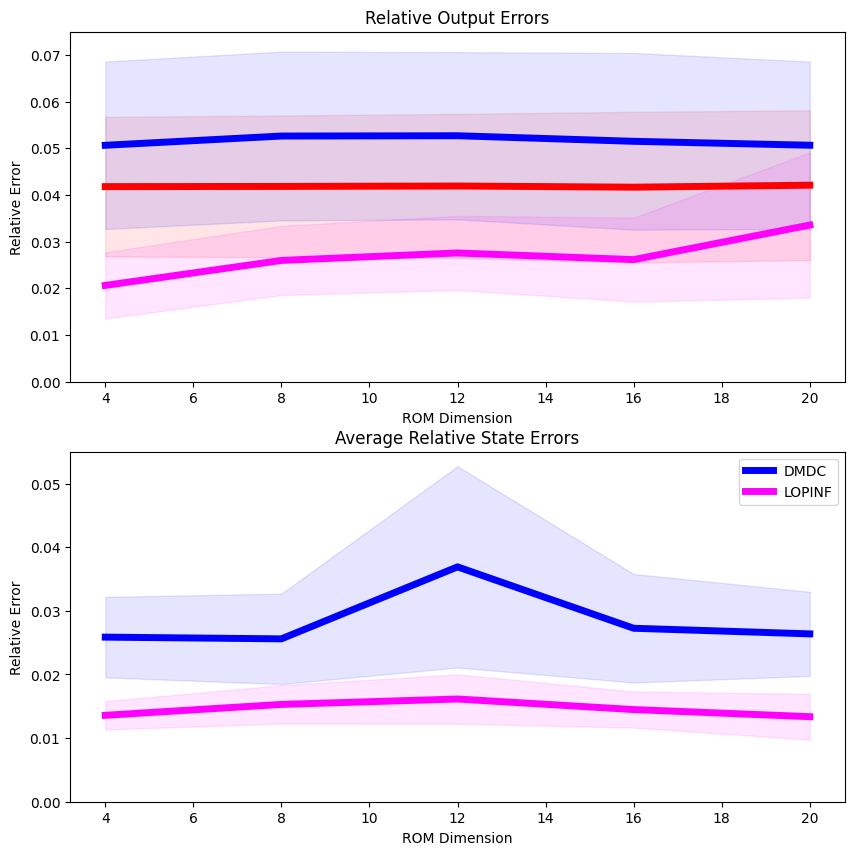

In [89]:
# Open Loop
# Plot average relative errors for output and state estimates on two vertical subplots with standard deviations in shaded regions (era is red, dmdc is blue, lopinf is magenta)
fig, axs = plt.subplots(2,1,figsize=(10,10))
# Output rel errors
axs[0].plot(ns_ROM, avg_error_output_era_rel_ol, label="ERA", color="red", linewidth=5)
axs[0].fill_between(ns_ROM, avg_error_output_era_rel_ol-std_error_output_era_rel_ol, avg_error_output_era_rel_ol+std_error_output_era_rel_ol, color="red", alpha=0.1)
axs[0].plot(ns_ROM, avg_error_output_dmdc_rel_ol, label="DMDC", color="blue", linewidth=5)
axs[0].fill_between(ns_ROM, avg_error_output_dmdc_rel_ol-std_error_output_dmdc_rel_ol, avg_error_output_dmdc_rel_ol+std_error_output_dmdc_rel_ol, color="blue", alpha=0.1)
axs[0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel_ol, label="LOPINF", color="magenta", linewidth=5)
axs[0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel_ol-std_error_output_lopinf_rel_ol, avg_error_output_lopinf_rel_ol+std_error_output_lopinf_rel_ol, color="magenta", alpha=0.1)
axs[0].set_title("Relative Output Errors")
axs[0].set_xlabel("ROM Dimension")
axs[0].set_ylabel("Relative Error")
# start from 0 on y-axis
axs[0].set_ylim(0,0.075)
# axs[0].legend()
# State rel errors
axs[1].plot(ns_ROM, avg_error_state_dmdc_rel_ol, label="DMDC", color="blue", linewidth=5)
axs[1].fill_between(ns_ROM, avg_error_state_dmdc_rel_ol-std_error_state_dmdc_rel_ol, avg_error_state_dmdc_rel_ol+std_error_state_dmdc_rel_ol, color="blue", alpha=0.1)
axs[1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel_ol, label="LOPINF", color="magenta", linewidth=5)
axs[1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel_ol-std_error_state_lopinf_rel_ol, avg_error_state_lopinf_rel_ol+std_error_state_lopinf_rel_ol, color="magenta", alpha=0.1)
axs[1].set_title("Average Relative State Errors")
axs[1].set_xlabel("ROM Dimension")
axs[1].set_ylabel("Relative Error")
axs[1].set_ylim(0,0.055)
axs[1].legend()
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/relativeErrorsOpenLoop.pdf", format="pdf")

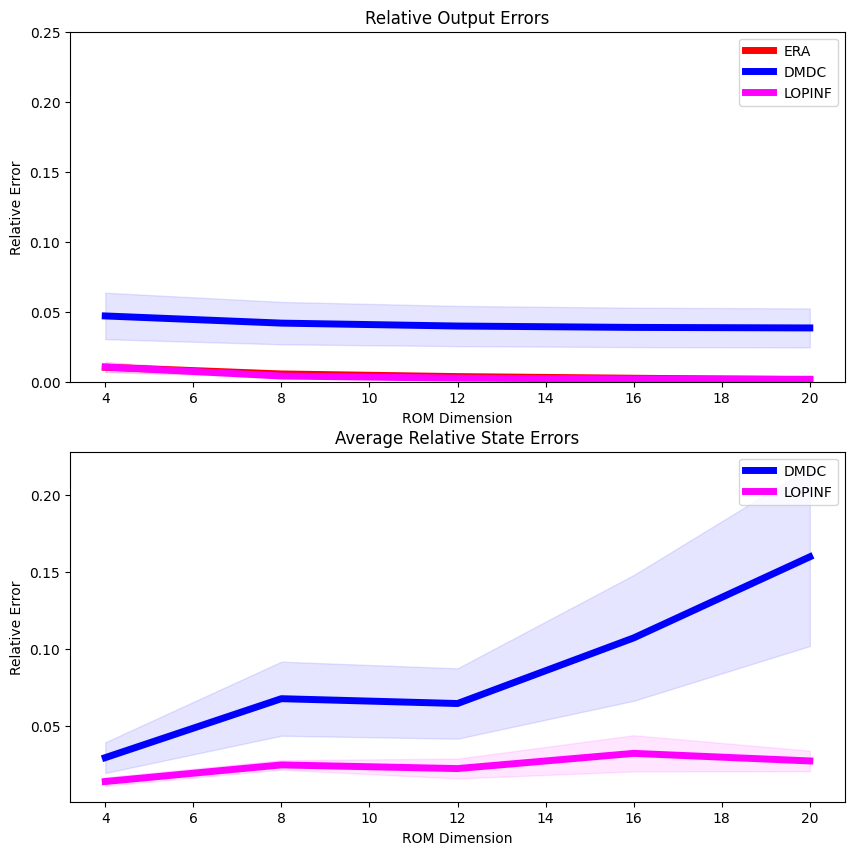

In [90]:
# Closed Loop
# Plot average relative errors for output and state estimates on two vertical subplots with standard deviations in shaded regions (era is red, dmdc is blue, lopinf is magenta)
fig, axs = plt.subplots(2,1,figsize=(10,10))
# Output rel errors
axs[0].plot(ns_ROM, avg_error_output_era_rel_cl, label="ERA", color="red", linewidth=5)
axs[0].fill_between(ns_ROM, avg_error_output_era_rel_cl-std_error_output_era_rel_cl, avg_error_output_era_rel_cl+std_error_output_era_rel_cl, color="red", alpha=0.1)
axs[0].plot(ns_ROM, avg_error_output_dmdc_rel_cl, label="DMDC", color="blue", linewidth=5)
axs[0].fill_between(ns_ROM, avg_error_output_dmdc_rel_cl-std_error_output_dmdc_rel_cl, avg_error_output_dmdc_rel_cl+std_error_output_dmdc_rel_cl, color="blue", alpha=0.1)
axs[0].plot(ns_ROM_lopinf, avg_error_output_lopinf_rel_cl, label="LOPINF", color="magenta", linewidth=5)
axs[0].fill_between(ns_ROM_lopinf, avg_error_output_lopinf_rel_cl-std_error_output_lopinf_rel_cl, avg_error_output_lopinf_rel_cl+std_error_output_lopinf_rel_cl, color="magenta", alpha=0.1)
axs[0].set_title("Relative Output Errors")
axs[0].set_xlabel("ROM Dimension")
axs[0].set_ylabel("Relative Error")
axs[0].set_ylim(0,0.065)
axs[0].legend()
# State rel errors
axs[1].plot(ns_ROM, avg_error_state_dmdc_rel_cl, label="DMDC", color="blue", linewidth=5)
axs[1].fill_between(ns_ROM, avg_error_state_dmdc_rel_cl-std_error_state_dmdc_rel_cl, avg_error_state_dmdc_rel_cl+std_error_state_dmdc_rel_cl, color="blue", alpha=0.1)
axs[1].plot(ns_ROM_lopinf, avg_error_state_lopinf_rel_cl, label="LOPINF", color="magenta", linewidth=5)
axs[1].fill_between(ns_ROM_lopinf, avg_error_state_lopinf_rel_cl-std_error_state_lopinf_rel_cl, avg_error_state_lopinf_rel_cl+std_error_state_lopinf_rel_cl, color="magenta", alpha=0.1)
axs[1].set_title("Average Relative State Errors")
axs[1].set_xlabel("ROM Dimension")
axs[1].set_ylabel("Relative Error")
axs[0].set_ylim(0,0.25)
axs[1].legend()
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/relativeErrorsClosedLoop.pdf", format="pdf", transparent=True)


# Control Performance Figure

In [91]:
# Setup filepath for reading data
filepath_era_slow = config["currentDirectory"] + "data/verificationData/controlTest23/"
filepath_era_fast = config["currentDirectory"] + "data/verificationData/controlTest22/"
filepath_dmdc_slow = config["currentDirectory"] + "data/verificationData/controlTest25/"
filepath_dmdc_fast = config["currentDirectory"] + "data/verificationData/controlTest24/"
filepath_lopinf_slow = config["currentDirectory"] + "data/verificationData/controlTest21/"
filepath_lopinf_fast = config["currentDirectory"] + "data/verificationData/controlTest20/"

timesteps = 3000
trackedIndices = np.arange(7,17,2)
zindices = np.arange(1,41,2)

In [92]:
# Load in input data from npy file
# ERA slow
data_era_slow = np.load(filepath_era_slow + "processedData_policySeed_0.npz")
U_fom_era_slow = data_era_slow["inputData"].T
# ERA fast
data_era_fast = np.load(filepath_era_fast + "processedData_policySeed_0.npz")
U_fom_era_fast = data_era_fast["inputData"].T
# DMDC slow
data_dmdc_slow = np.load(filepath_dmdc_slow + "processedData_policySeed_0.npz")
U_fom_dmdc_slow = data_dmdc_slow["inputData"].T
# DMDC fast
data_dmdc_fast = np.load(filepath_dmdc_fast + "processedData_policySeed_0.npz")
U_fom_dmdc_fast = data_dmdc_fast["inputData"].T
# LOPINF slow
data_lopinf_slow = np.load(filepath_lopinf_slow + "processedData_policySeed_0.npz")
U_fom_lopinf_slow = data_lopinf_slow["inputData"].T
# LOPINF fast
data_lopinf_fast = np.load(filepath_lopinf_fast + "processedData_policySeed_0.npz")
U_fom_lopinf_fast = data_lopinf_fast["inputData"].T

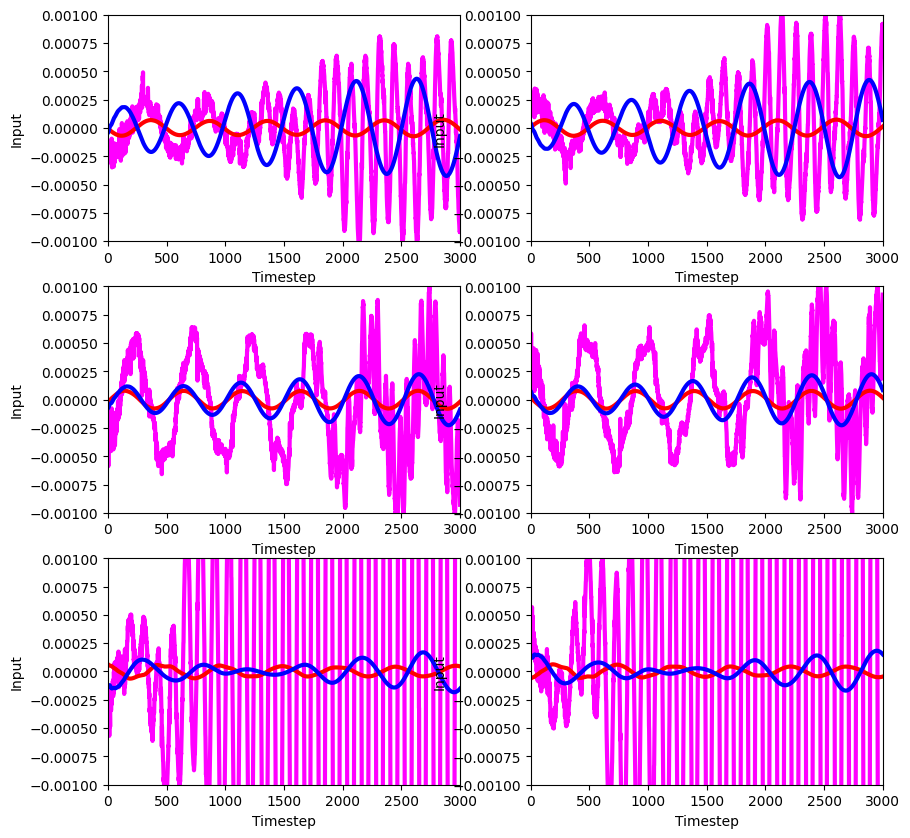

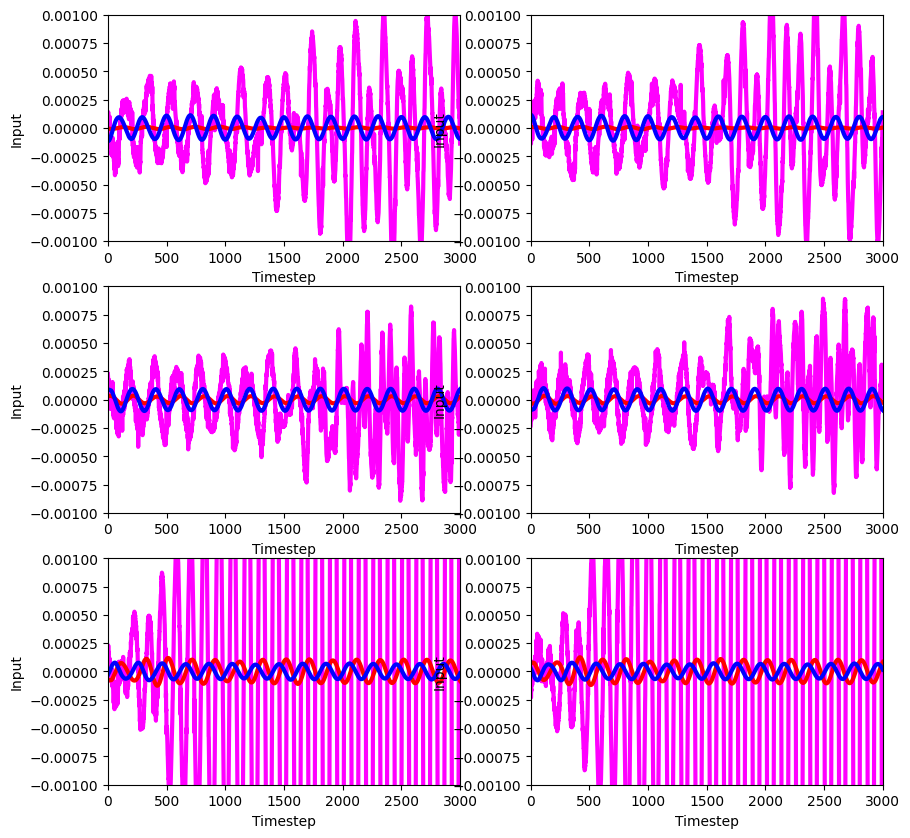

In [93]:
# Plot all 6 inputs separately on different subplots in a 3x2 grid where each subplot is a different input
# Slow trials
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    axs[i//2, i%2].plot(U_fom_lopinf_slow[i,:timesteps], label="Input " + str(i), color="magenta", linewidth=3)
    axs[i//2, i%2].plot(U_fom_era_slow[i,:timesteps], label="Input " + str(i), color="red", linewidth=3)
    axs[i//2, i%2].plot(U_fom_dmdc_slow[i,:timesteps], label="Input " + str(i), color="blue", linewidth=3)
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Input")
    # Set limits from -0.001 to 0.001
    axs[i//2, i%2].set_ylim(-0.001, 0.001)
    # Set xlim to the number of timesteps
    axs[i//2, i%2].set_xlim(0, timesteps)

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/inputComparisonSlow.pdf", format="pdf", transparent=True)
# Fast trials
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    axs[i//2, i%2].plot(U_fom_lopinf_fast[i,:timesteps], label="Input " + str(i), color="magenta", linewidth=3)
    axs[i//2, i%2].plot(U_fom_era_fast[i,:timesteps], label="Input " + str(i), color="red", linewidth=3)
    axs[i//2, i%2].plot(U_fom_dmdc_fast[i,:timesteps], label="Input " + str(i), color="blue", linewidth=3)
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Input")
    # Set limits from -0.001 to 0.001
    axs[i//2, i%2].set_ylim(-0.001, 0.001)
    # Set xlim to the number of timesteps
    axs[i//2, i%2].set_xlim(0, timesteps)
# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/inputComparisonFast.pdf", format="pdf", transparent=True)

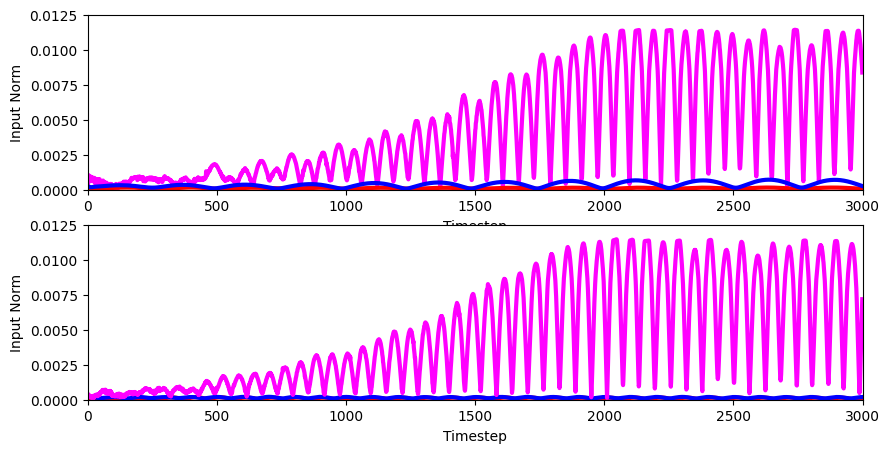

In [94]:
# Compute Norms of inputs over time for each method with slow and fast trials on different subplots
# Slow trials
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
# LOPINF
norms_lopinf_slow = np.linalg.norm(U_fom_lopinf_slow[:,:timesteps], axis=0)
axs[0].plot(norms_lopinf_slow, label="LOPINF", color="magenta", linewidth=3)

# ERA
norms_era_slow = np.linalg.norm(U_fom_era_slow[:,:timesteps], axis=0)
axs[0].plot(norms_era_slow, label="ERA", color="red", linewidth=3)
# DMDC
norms_dmdc_slow = np.linalg.norm(U_fom_dmdc_slow[:,:timesteps], axis=0)
axs[0].plot(norms_dmdc_slow, label="DMDC", color="blue", linewidth=3)

# Set ylimits from 0 to 0.0125
axs[0].set_ylim(0, 0.0125)
# Set xlimits from 0 to timesteps
axs[0].set_xlim(0, timesteps)
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Input Norm")
# Fast trials
# ERA
norms_era_fast = np.linalg.norm(U_fom_era_fast[:,:timesteps], axis=0)
axs[1].plot(norms_era_fast, label="ERA", color="red", linewidth=3)
# DMDC
norms_dmdc_fast = np.linalg.norm(U_fom_dmdc_fast[:,:timesteps], axis=0)
axs[1].plot(norms_dmdc_fast, label="DMDC", color="blue", linewidth=3)
# LOPINF
norms_lopinf_fast = np.linalg.norm(U_fom_lopinf_fast[:,:timesteps], axis=0)
axs[1].plot(norms_lopinf_fast, label="LOPINF", color="magenta", linewidth=3)
# Set ylimits from 0 to 0.0125
axs[1].set_ylim(0, 0.0125)
# Set xlimits from 0 to timesteps
axs[1].set_xlim(0, timesteps)
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Input Norm")
plt.show()
# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/inputNorms.pdf", format="pdf", transparent=True)



In [95]:
# Read in output and reference data for each trial
# ERA slow
# Initialize arrays to store data from online observer
y_era_slow = np.zeros((40, timesteps)) 
y_ref_era_slow = np.zeros((40, timesteps)) 
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_era_slow + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_era_slow[:,i] = f["y"][()].squeeze()
        y_ref_era_slow[:,i] = f["y_ref"][()][:,0].squeeze()
# ERA fast
# Initialize arrays to store data from online observer
y_era_fast = np.zeros((40, timesteps))
y_ref_era_fast = np.zeros((40, timesteps))
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_era_fast + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_era_fast[:,i] = f["y"][()].squeeze()
        y_ref_era_fast[:,i] = f["y_ref"][()][:,0].squeeze()
# DMDC slow
# Initialize arrays to store data from online observer
y_dmdc_slow = np.zeros((40, timesteps))
y_ref_dmdc_slow = np.zeros((40, timesteps))
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_dmdc_slow + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_dmdc_slow[:,i] = f["y"][()].squeeze()
        y_ref_dmdc_slow[:,i] = f["y_ref"][()][:,0].squeeze()
# DMDC fast
# Initialize arrays to store data from online observer
y_dmdc_fast = np.zeros((40, timesteps))
y_ref_dmdc_fast = np.zeros((40, timesteps))
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_dmdc_fast + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_dmdc_fast[:,i] = f["y"][()].squeeze()
        y_ref_dmdc_fast[:,i] = f["y_ref"][()][:,0].squeeze()
# LOPINF slow
# Initialize arrays to store data from online observer
y_lopinf_slow = np.zeros((40, timesteps))
y_ref_lopinf_slow = np.zeros((40, timesteps))
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_lopinf_slow + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_lopinf_slow[:,i] = f["y"][()].squeeze()
        y_ref_lopinf_slow[:,i] = f["y_ref"][()][:,0].squeeze()
# LOPINF fast
# Initialize arrays to store data from online observer
y_lopinf_fast = np.zeros((40, timesteps))
y_ref_lopinf_fast = np.zeros((40, timesteps))
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath_lopinf_fast + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_lopinf_fast[:,i] = f["y"][()].squeeze()
        y_ref_lopinf_fast[:,i] = f["y_ref"][()][:,0].squeeze()

In [96]:
# Compute tracking errors for each trial
# ERA slow
tracking_error_era_slow = y_era_slow - y_ref_era_slow
# ERA fast
tracking_error_era_fast = y_era_fast - y_ref_era_fast
# DMDC slow
tracking_error_dmdc_slow = y_dmdc_slow - y_ref_dmdc_slow
# DMDC fast
tracking_error_dmdc_fast = y_dmdc_fast - y_ref_dmdc_fast
# LOPINF slow
tracking_error_lopinf_slow = y_lopinf_slow - y_ref_lopinf_slow
# LOPINF fast
tracking_error_lopinf_fast = y_lopinf_fast - y_ref_lopinf_fast

In [97]:
# Compute RMS tracking error for tracked indices for each trial
# ERA slow
rms_tracking_error_era_slow = np.sqrt(np.mean(tracking_error_era_slow[trackedIndices,:]**2))
# ERA fast
rms_tracking_error_era_fast = np.sqrt(np.mean(tracking_error_era_fast[trackedIndices,:]**2))
# DMDC slow
rms_tracking_error_dmdc_slow = np.sqrt(np.mean(tracking_error_dmdc_slow[trackedIndices,:]**2))
# DMDC fast
rms_tracking_error_dmdc_fast = np.sqrt(np.mean(tracking_error_dmdc_fast[trackedIndices,:]**2))
# LOPINF slow
rms_tracking_error_lopinf_slow = np.sqrt(np.mean(tracking_error_lopinf_slow[trackedIndices,:]**2))
# LOPINF fast
rms_tracking_error_lopinf_fast = np.sqrt(np.mean(tracking_error_lopinf_fast[trackedIndices,:]**2))


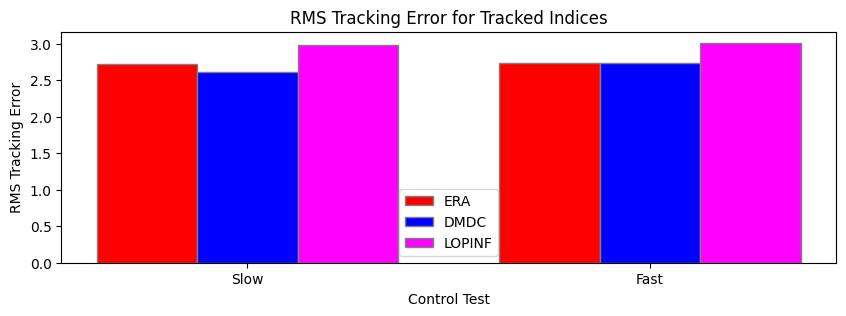

In [98]:
# Make bar plot of RMS tracking errors for each trial where slow and fast trials are grouped together (ERA is red, DMDC is blue, LOPINF is magenta)
fig, ax = plt.subplots(figsize=(10,3))
barWidth = 0.25
bar1 = np.array([rms_tracking_error_era_slow, rms_tracking_error_era_fast])
bar2 = np.array([rms_tracking_error_dmdc_slow, rms_tracking_error_dmdc_fast])
bar3 = np.array([rms_tracking_error_lopinf_slow, rms_tracking_error_lopinf_fast])
r1 = np.arange(len(bar1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
ax.bar(r1, bar1, color='red', width=barWidth, edgecolor='grey', label='ERA')
ax.bar(r2, bar2, color='blue', width=barWidth, edgecolor='grey', label='DMDC')
ax.bar(r3, bar3, color='magenta', width=barWidth, edgecolor='grey', label='LOPINF')
ax.set_xlabel('Control Test')
ax.set_ylabel('RMS Tracking Error')
ax.set_title('RMS Tracking Error for Tracked Indices')
ax.set_xticks([r + barWidth for r in range(len(bar1))])
ax.set_xticklabels(['Slow', 'Fast'])
ax.legend()
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/rmsTrackingError.pdf", format="pdf", transparent=True)


In [99]:
# Compute RMS tracking error for tracked indices over time for each trial
# ERA slow
rms_tracking_error_era_slow_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_era_slow_over_time[i] = np.sqrt(np.mean(tracking_error_era_slow[trackedIndices,i]**2))
# ERA fast
rms_tracking_error_era_fast_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_era_fast_over_time[i] = np.sqrt(np.mean(tracking_error_era_fast[trackedIndices,i]**2))
# DMDC slow
rms_tracking_error_dmdc_slow_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_dmdc_slow_over_time[i] = np.sqrt(np.mean(tracking_error_dmdc_slow[trackedIndices,i]**2))
# DMDC fast
rms_tracking_error_dmdc_fast_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_dmdc_fast_over_time[i] = np.sqrt(np.mean(tracking_error_dmdc_fast[trackedIndices,i]**2))
# LOPINF slow
rms_tracking_error_lopinf_slow_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_lopinf_slow_over_time[i] = np.sqrt(np.mean(tracking_error_lopinf_slow[trackedIndices,i]**2))
# LOPINF fast
rms_tracking_error_lopinf_fast_over_time = np.zeros(timesteps)
for i in range(timesteps):
    rms_tracking_error_lopinf_fast_over_time[i] = np.sqrt(np.mean(tracking_error_lopinf_fast[trackedIndices,i]**2))



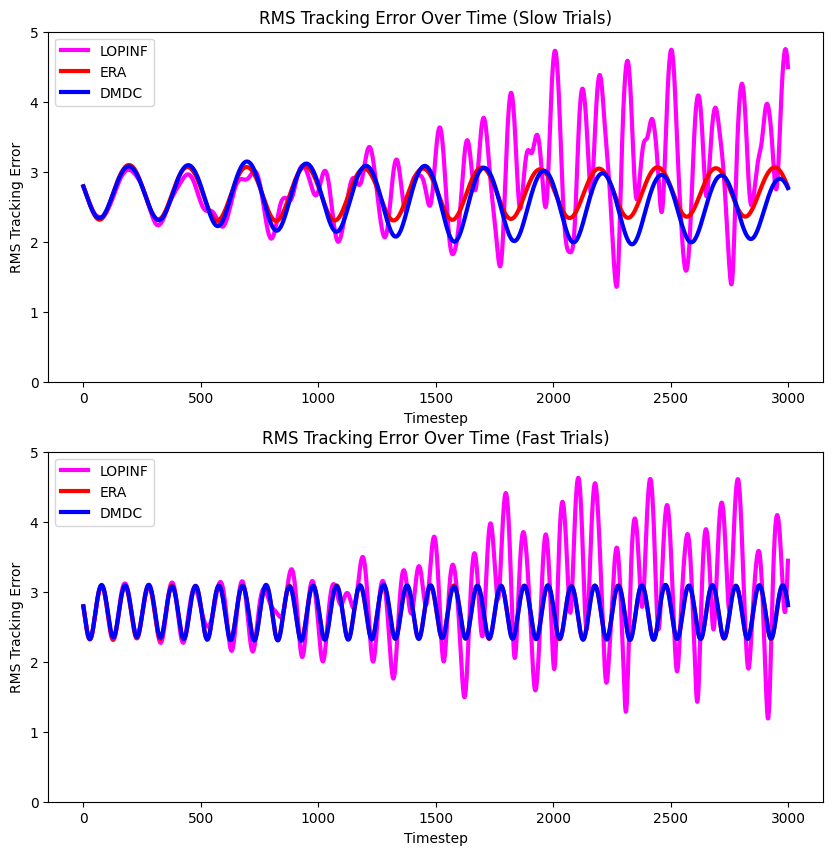

In [100]:
# Plot RMS tracking error for tracked indices over time for each trial (ERA is red, DMDC is blue, LOPINF is magenta) on two vertical subplots
fig, axs = plt.subplots(2,1,figsize=(10,10))
# Slow trials
axs[0].plot(np.arange(timesteps), rms_tracking_error_lopinf_slow_over_time, label="LOPINF", color="magenta", linewidth=3)
axs[0].plot(np.arange(timesteps), rms_tracking_error_era_slow_over_time, label="ERA", color="red", linewidth=3)
axs[0].plot(np.arange(timesteps), rms_tracking_error_dmdc_slow_over_time, label="DMDC", color="blue", linewidth=3)
axs[0].set_title("RMS Tracking Error Over Time (Slow Trials)")
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("RMS Tracking Error")
axs[0].set_ylim(0,5)
axs[0].legend()
# Fast trials
axs[1].plot(np.arange(timesteps), rms_tracking_error_lopinf_fast_over_time, label="LOPINF", color="magenta", linewidth=3)
axs[1].plot(np.arange(timesteps), rms_tracking_error_era_fast_over_time, label="ERA", color="red", linewidth=3)
axs[1].plot(np.arange(timesteps), rms_tracking_error_dmdc_fast_over_time, label="DMDC", color="blue", linewidth=3)   
axs[1].set_title("RMS Tracking Error Over Time (Fast Trials)")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("RMS Tracking Error")
axs[1].legend()
axs[1].set_ylim(0,5)

plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/rmsTrackingErrorOverTime.pdf", format="pdf", transparent=True)


In [101]:
# Compute RMS errors for each z index for each trial
# ERA slow
rms_error_era_slow = np.sqrt(np.mean(tracking_error_era_slow[zindices,:]**2, axis=1))
# ERA fast
rms_error_era_fast = np.sqrt(np.mean(tracking_error_era_fast[zindices,:]**2, axis=1))
# DMDC slow
rms_error_dmdc_slow = np.sqrt(np.mean(tracking_error_dmdc_slow[zindices,:]**2, axis=1))
# DMDC fast
rms_error_dmdc_fast = np.sqrt(np.mean(tracking_error_dmdc_fast[zindices,:]**2, axis=1))
# LOPINF slow
rms_error_lopinf_slow = np.sqrt(np.mean(tracking_error_lopinf_slow[zindices,:]**2, axis=1))
# LOPINF fast
rms_error_lopinf_fast = np.sqrt(np.mean(tracking_error_lopinf_fast[zindices,:]**2, axis=1))


In [102]:
# Find max reference value for each z index
max_ref_era_slow = np.max(y_ref_era_slow[zindices,:], axis=1)
max_ref_era_fast = np.max(y_ref_era_fast[zindices,:], axis=1)
max_ref_dmdc_slow = np.max(y_ref_dmdc_slow[zindices,:], axis=1)
max_ref_dmdc_fast = np.max(y_ref_dmdc_fast[zindices,:], axis=1)
max_ref_lopinf_slow = np.max(y_ref_lopinf_slow[zindices,:], axis=1)
max_ref_lopinf_fast = np.max(y_ref_lopinf_fast[zindices,:], axis=1)


In [103]:
# Compute relative RMS errors for each z index for each trial
# ERA slow
rel_rms_error_era_slow = rms_error_era_slow / max_ref_era_slow
# ERA fast
rel_rms_error_era_fast = rms_error_era_fast / max_ref_era_fast
# DMDC slow
rel_rms_error_dmdc_slow = rms_error_dmdc_slow / max_ref_dmdc_slow
# DMDC fast
rel_rms_error_dmdc_fast = rms_error_dmdc_fast / max_ref_dmdc_fast
# LOPINF slow
rel_rms_error_lopinf_slow = rms_error_lopinf_slow / max_ref_lopinf_slow
# LOPINF fast
rel_rms_error_lopinf_fast = rms_error_lopinf_fast / max_ref_lopinf_fast


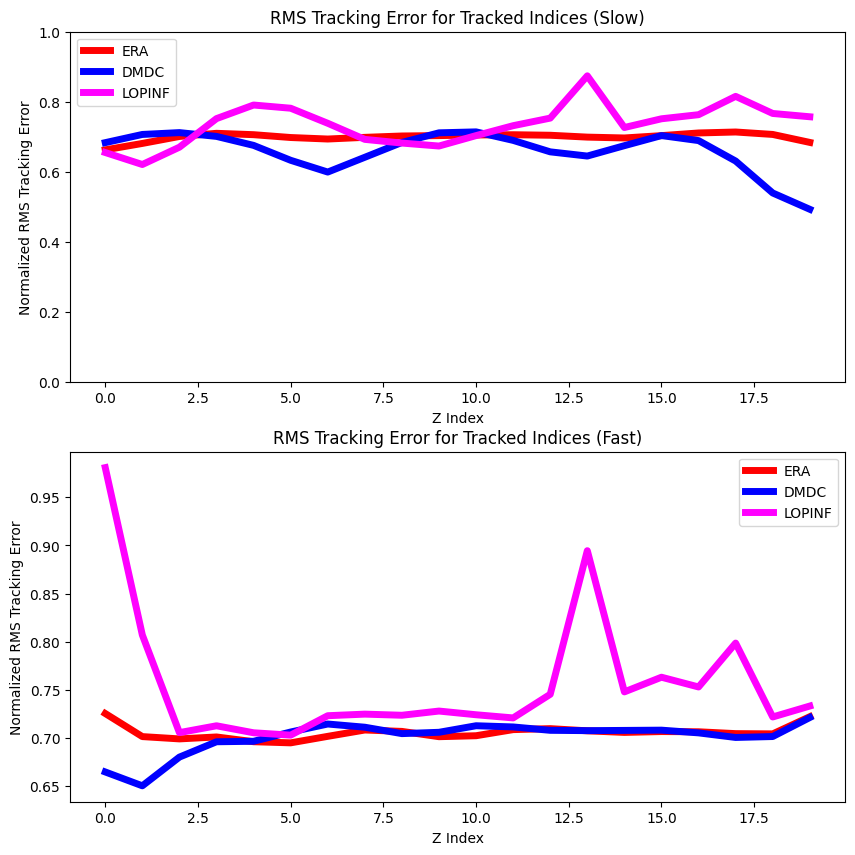

In [104]:
# Make 2 vertical subplots
fig, axs = plt.subplots(2,1,figsize=(10,10))
# Plot RMS tracking errrors for each z index normalized by max reference value for each slow trial on the first subplot with z indices reversed
axs[0].plot(np.flip(rel_rms_error_era_slow), label="ERA", color="red", linewidth=5)
axs[0].plot(np.flip(rel_rms_error_dmdc_slow), label="DMDC", color="blue", linewidth=5)
axs[0].plot(np.flip(rel_rms_error_lopinf_slow), label="LOPINF", color="magenta", linewidth=5)
axs[0].set_title("RMS Tracking Error for Tracked Indices (Slow)")
axs[0].set_xlabel("Z Index")
axs[0].set_ylabel("Normalized RMS Tracking Error")
axs[0].set_ylim(0,0.9)
axs[0].legend()
# Plot RMS tracking errrors for each z index for each fast trial on the second subplot with z indices reversed
axs[1].plot(np.flip(rel_rms_error_era_fast), label="ERA", color="red", linewidth=5)
axs[1].plot(np.flip(rel_rms_error_dmdc_fast), label="DMDC", color="blue", linewidth=5)
axs[1].plot(np.flip(rel_rms_error_lopinf_fast), label="LOPINF", color="magenta", linewidth=5)
axs[1].set_title("RMS Tracking Error for Tracked Indices (Fast)")
axs[1].set_xlabel("Z Index")
axs[1].set_ylabel("Normalized RMS Tracking Error")
axs[1].legend()
axs[0].set_ylim(0,1.0)
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/normalizedRmsTrackingErrorOverZIndices.pdf", format="pdf", transparent=True)

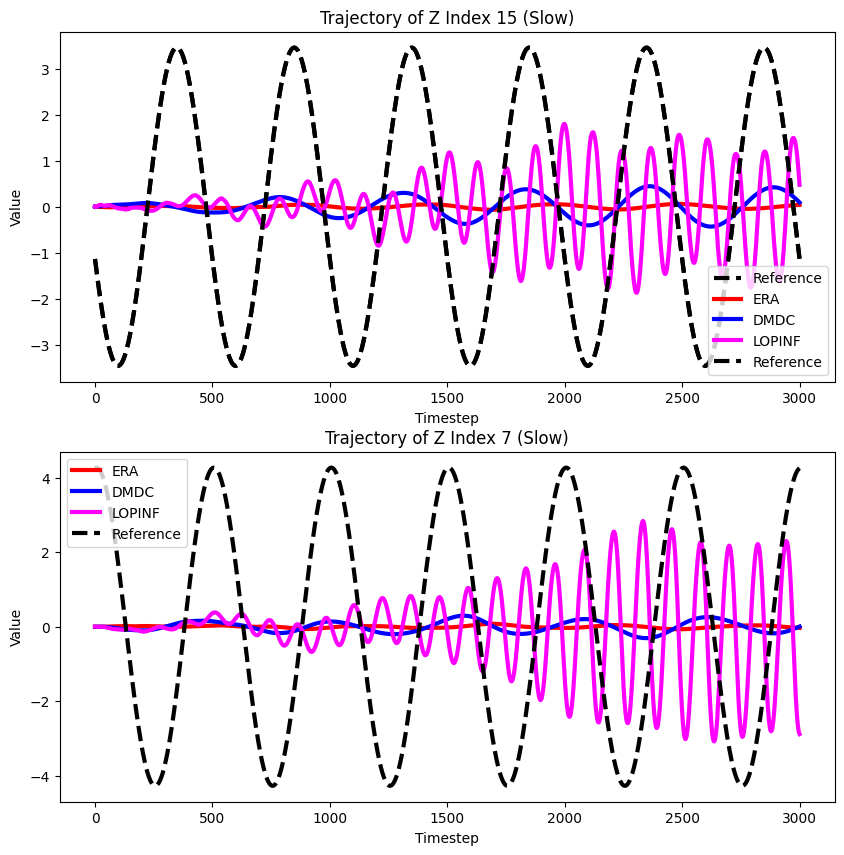

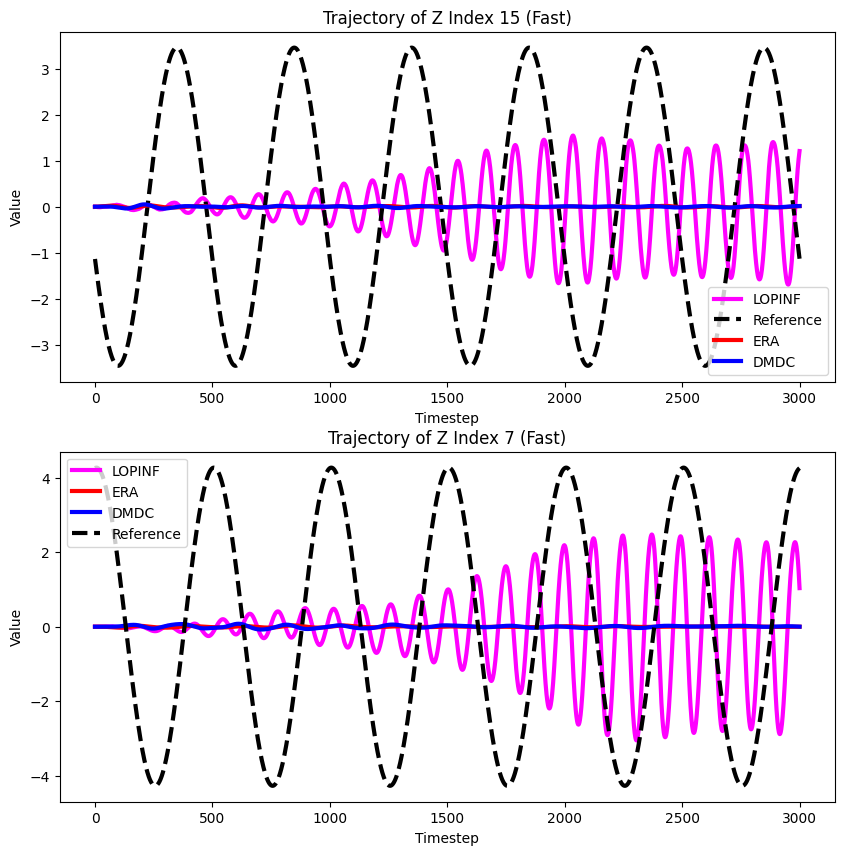

In [105]:
# Plot trajectories of first and last point in tracked indices for each model (ERA is red, DMDC is blue, LOPINF is magenta). Trajectories are plotted in solid lines and reference values are plotted in dashed lines 
# Slow trials
fig, axs = plt.subplots(2,1,figsize=(10,10))
# First point
indexToPlot = trackedIndices[-1]
axs[0].plot(y_ref_era_slow[indexToPlot,:], label="Reference", color="black", linestyle="--", linewidth=3)
axs[0].plot(y_era_slow[indexToPlot,:], label="ERA", color="red", linewidth=3)
axs[0].plot(y_dmdc_slow[indexToPlot,:], label="DMDC", color="blue", linewidth=3)
axs[0].plot(y_lopinf_slow[indexToPlot,:], label="LOPINF", color="magenta", linewidth=3)
axs[0].plot(y_ref_era_slow[indexToPlot,:], label="Reference", color="black", linestyle="--", linewidth=3)
axs[0].set_title("Trajectory of Z Index " + str(indexToPlot) + " (Slow)")
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Value")
axs[0].legend()
# Last point
indexToPlot = trackedIndices[0]
axs[1].plot(y_era_slow[indexToPlot,:], label="ERA", color="red", linewidth=3)
axs[1].plot(y_dmdc_slow[indexToPlot,:], label="DMDC", color="blue", linewidth=3)
axs[1].plot(y_lopinf_slow[indexToPlot,:], label="LOPINF", color="magenta", linewidth=3)
axs[1].plot(y_ref_era_slow[indexToPlot,:], label="Reference", color="black", linestyle="--", linewidth=3)
axs[1].set_title("Trajectory of Z Index " + str(indexToPlot) + " (Slow)")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Value")
axs[1].legend()
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/TrackingTrajectoriesSlow.pdf", format="pdf", transparent=True)

# Fast trials
fig, axs = plt.subplots(2,1,figsize=(10,10))
# First point
indexToPlot = trackedIndices[-1]
axs[0].plot(y_lopinf_fast[indexToPlot,:], label="LOPINF", color="magenta", linewidth=3)
axs[0].plot(y_ref_era_slow[indexToPlot,:], label="Reference", color="black", linestyle="--", linewidth=3)
axs[0].plot(y_era_fast[indexToPlot,:], label="ERA", color="red", linewidth=3)
axs[0].plot(y_dmdc_fast[indexToPlot,:], label="DMDC", color="blue", linewidth=3)
axs[0].set_title("Trajectory of Z Index " + str(indexToPlot) + " (Fast)")
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Value")
axs[0].legend()
# Last point
indexToPlot = trackedIndices[0]
axs[1].plot(y_lopinf_fast[indexToPlot,:], label="LOPINF", color="magenta", linewidth=3)
axs[1].plot(y_era_fast[indexToPlot,:], label="ERA", color="red", linewidth=3)
axs[1].plot(y_dmdc_fast[indexToPlot,:], label="DMDC", color="blue", linewidth=3)
axs[1].plot(y_ref_era_slow[indexToPlot,:], label="Reference", color="black", linestyle="--", linewidth=3)
axs[1].set_title("Trajectory of Z Index " + str(indexToPlot) + " (Fast)")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Value")
axs[1].legend()
plt.show()

# Save the figure as a .pdf file
fig.savefig(config["currentDirectory"] + "data/figures/TrackingTrajectoriesFast.pdf", format="pdf", transparent=True)

